### Figure
#### Rasters for schematic 

In [6]:
cd /Users/cl1704/PycharmProjects/embedding_dimension/BWM

/Users/cl1704/PycharmProjects/embedding_dimension/BWM


In [7]:
import datajoint as dj_langdon
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from datajoint_tables import *
dj_langdon.config['database.host'] = 'datajoint-tengel.pni.princeton.edu'
dj_langdon.config['database.user'] = 'cl1704'
dj_langdon.config['database.password'] = 'wuxty2-mYdxej-kerxaq'
schema = dj_langdon.schema('langdon_ibl_manifold')
schema.spawn_missing_classes()

In [8]:
original_df = pd.DataFrame((Experiment_1() ).proj('eid','beryl','cosmos','n_neurons','variance','inertia','n_trials','null_param','activity_std','k','responses','p','null_inertia').fetch())
original_df = original_df[original_df.n_neurons>=100]

In [9]:
original_df.shape

(268, 18)

In [2]:
def session_data(eid):
    data = (Session() & {'eid': eid}).fetch1()
    stimon_times = data['stimon_times']
    choices = data['choice']
    contrasts = np.nan_to_num(-data['contrast_left'], copy=True, nan=1.0) * np.nan_to_num(
        data['contrast_right'], copy=True, nan=1.0)
    contrasts[contrasts == 0.] = 0
    sides = np.sign(contrasts)
    p_left = data['probability_left']
    previous_choice = np.roll(choices,1)
    return stimon_times, choices, sides




def binned_trials(spike_times,stimon_times,choices,sides,n_time, trial_length):
    statistics = []
    p_values = []
    for neuron in range(spike_times.shape[0]):
        neuron_spikes = spike_times[neuron]
        pre_spikes = []
        post_spikes = []
        for trial in range(1, len(stimon_times)):
            # Align to stimon
            pre_trial_spikes = neuron_spikes[np.logical_and(neuron_spikes > stimon_times[trial] - trial_length,
                                                            neuron_spikes < stimon_times[trial])]
            pre_spikes.append(len(pre_trial_spikes))

            post_trial_spikes = neuron_spikes[np.logical_and(neuron_spikes > stimon_times[trial],
                                                             neuron_spikes < stimon_times[trial] + trial_length)]
            post_spikes.append(len(post_trial_spikes))

        try:
            statistic, p = ks_2samp(pre_spikes, post_spikes)
            statistics.append(statistic)
            p_values.append(p)
        except:
            statistics.append(0.0)
            p_values.append(1.0)

    statistics = np.array(statistics)
    p_values = np.array(p_values)

    good_units = np.argwhere(np.array(p_values) < .05)[:, 0]

    rows = []
    for neuron in good_units:
        neuron_spikes = spike_times[neuron]
        for trial in range(1,len(stimon_times)):
            # Align to stimon
            trial_spikes = neuron_spikes[np.logical_and(neuron_spikes > stimon_times[trial],
                                                        neuron_spikes < stimon_times[trial] + trial_length)]
            hist, _ = np.histogram(trial_spikes, bins=n_time,
                                   range=(stimon_times[trial], stimon_times[trial] + trial_length))
            response = hist * n_time / trial_length
            rows.append({
                'trial':trial,
                'choice': choices[trial],
                'side': sides[trial],
                'neuron': neuron,
                'response': response})

    df = pd.DataFrame(rows)

    return df

In [16]:
n_time = 10
n_splits = 10
trial_length = .5
n_active = 100
beryl = 'ACAd'
eid = '259927fd-7563-4b03-bc5d-17b4d0fa7a55'
sigma = 2
# Fetch data
spike_times = (Cluster() & {'beryl': beryl} & {'eid': eid}).fetch('spike_times')
stimon_times, choices, sides = session_data(eid)
n_trials = len(choices)
print(n_trials)
# Build response matrix. 
response_df = binned_trials(spike_times, stimon_times, choices,
                            sides, n_time, trial_length)

646


/var/folders/9_/yjc4d8zx4tj6kw6h4xgj4zd80000gn/T/ipykernel_98821/3803476922.py:34: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  statistic, p = ks_2samp(pre_spikes, post_spikes)


In [17]:
response_df = response_df[response_df.trial<25]

In [18]:
response_df = response_df.groupby(['neuron'])['response'].apply(lambda x: np.hstack(x)).reset_index()

In [19]:
responses = np.stack(response_df.response.values)

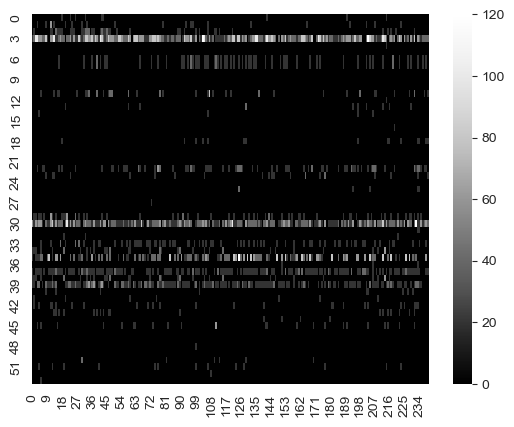

In [22]:
plt.figure()
sns.heatmap(responses,cmap='Greys_r')
plt.savefig('/Users/cl1704/PycharmProjects/embedding_dimension/BWM/Figures/Figure_schematicraster.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )